In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Client/Asghar

/content/drive/MyDrive/Client/Asghar


#Data Preprocessing

In [ ]:
import cv2,os
data_path='/content/drive/MyDrive/Client/Asghar/mask_datasets/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [ ]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

#Recale and assign  catagorical lables

In [ ]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)
from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

In [ ]:
new_target.shape

(1376, 2)

In [ ]:
np.save('images.npy',data)
np.save('labels.npy',new_target)

#CNN Model

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [5]:
import numpy as np
data=np.load('images.npy')
new_target=np.load('labels.npy')

In [6]:
data.shape

(1376, 100, 100, 1)

In [7]:
data.shape[1:]

(100, 100, 1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 200)       2000      
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 200)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 200)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 100)       180100    
_________________________________________________________________
activation_2 (Activation)    (None, 47, 47, 100)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 52900)            

#Splittiong data into traning and testing

In [10]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,new_target,test_size=0.1)

In [11]:
train_data.shape

(1238, 100, 100, 1)

In [12]:
train_target.shape

(1238, 2)

In [13]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)


Train on 990 samples, validate on 248 samples
Epoch 1/100
990/990 [==============================] - 8s 8ms/step - loss: 0.6273 - accuracy: 0.6394 - val_loss: 0.5068 - val_accuracy: 0.7621
Epoch 2/100
990/990 [==============================] - 1s 810us/step - loss: 0.3853 - accuracy: 0.8374 - val_loss: 0.2783 - val_accuracy: 0.8871
Epoch 3/100
990/990 [==============================] - 1s 810us/step - loss: 0.2154 - accuracy: 0.9232 - val_loss: 0.2289 - val_accuracy: 0.9315
Epoch 4/100
990/990 [==============================] - 1s 805us/step - loss: 0.1446 - accuracy: 0.9444 - val_loss: 0.1711 - val_accuracy: 0.9274
Epoch 5/100
990/990 [==============================] - 1s 806us/step - loss: 0.0984 - accuracy: 0.9677 - val_loss: 0.1127 - val_accuracy: 0.9516
Epoch 6/100
990/990 [==============================] - 1s 814us/step - loss: 0.0706 - accuracy: 0.9737 - val_loss: 0.1928 - val_accuracy: 0.9516
Epoch 7/100
990/990 [==============================] - 1s 798us/step - loss: 0.0647 -

In [14]:
from matplotlib import pyplot as plt

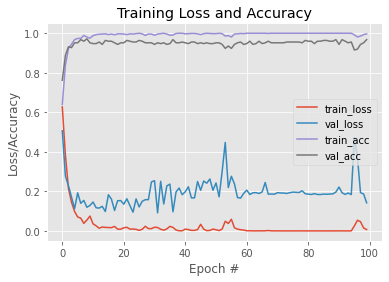

In [15]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

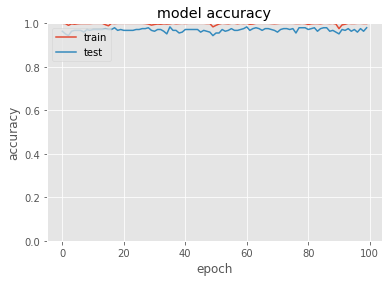

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0, 1))
plt.legend(['train', 'test'], loc='upper left');
plt.savefig('acc_graph.png')

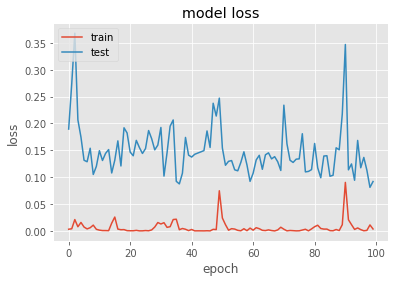

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_graph.png')
plt.show()

In [ ]:
y_pred = model.predict(test_data)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(test_target, axis=1), np.argmax(y_pred, axis=1))

0.9710144927536232

Confusion matrix, without normalization
[[61  3]
 [ 1 73]]


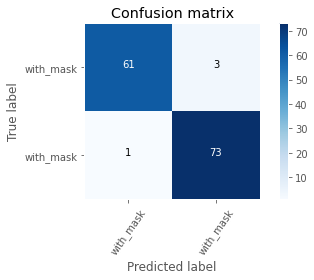

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.grid(False)
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
cm = confusion_matrix(np.argmax(test_target, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['with_mask', 'with_mask']
plot_confusion_matrix(cm, cm_plot_label)

In [ ]:
\